<a href="https://colab.research.google.com/github/hany606/PAI_Fall21IU/blob/main/Assignments/Assignment5/PAI_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source: the code was built on this tutorial: https://www.thepythoncode.com/article/build-spam-classifier-keras-python

Student: Hany Hamed
Assignment 5 - PAI Course


Please use Google Colab to run the notebook

Sources:
* https://www.thepythoncode.com/article/build-spam-classifier-keras-python
* https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
* https://towardsdatascience.com/nlp-detecting-spam-messages-with-tensorflow-b12195b8cf0e

## Setup Env

In [2]:
!pip install gdown
!pip install tqdm
!pip install keras-metrics
!pip install mglearn

In [3]:
from IPython.display import clear_output

In [4]:
!gdown https://drive.google.com/uc?id=1ffKtoa5y6MlXfzTr79lJ1OnV8u9Z96WH
!unzip smsspamcollection.zip
clear_output()

In [5]:
# Source: https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
clear_output()

In [6]:
!ls

cache		   glove.6B.300d.txt  glove.6B.zip.1  sample_data
glove.6B.100d.txt  glove.6B.50d.txt   glove.6B.zip.2  SMSSpamCollection.txt
glove.6B.200d.txt  glove.6B.zip       readme	      smsspamcollection.zip


In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import keras_metrics as km
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Data Loading

In [8]:

data = []
mx_length = 0
# Read/Parse the data
with open("SMSSpamCollection.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        e = line.split("\t")
        # data.append([e[0], "".join(e[1:])])
        # data.append([np.array([0,1]) if e[0] == "ham" else np.array([1,0]), "".join(e[1:])])
        data.append([0 if e[0] == "ham" else 1, "".join(e[1:])])
        mx_length = max(mx_length, len(e[1]))

# mx_length = ?
# Add it to pandas
df = pd.DataFrame(np.array(data).reshape((-1,2)), columns=["labels", "txt"])
df.head(5)
# df["labels"].head(5)

,labels,txt
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
tokenizer = Tokenizer() # Tokenizer in order to tokenize the txt
tokenizer.fit_on_texts(df["txt"])
X = np.array(tokenizer.texts_to_sequences(df["txt"]))
X = pad_sequences(X, maxlen=mx_length)  # pad the txt to have the same length
Y = np.array(df["labels"], dtype=np.int8)
Y = to_categorical(Y)   #-> Converts a class vector (integers) to binary class matrix.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=123)
print(f"x_train shape: {x_train.shape}\ty_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}\ty_test shape: {y_test.shape}")

x_train shape: (5016, 911)	y_train shape: (5016, 2)
x_test shape: (558, 911)	y_test shape: (558, 2)


In [11]:
print(X[0],Y[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [12]:
print("% of test data to all data:", len(x_test)/(len(x_train)+len(x_test)))
print('% of spam samples in train set:', sum([yi[0] == 0 for yi in y_train]) / len(y_train))
print('% of spam samples in test set:', sum([yi[0] == 0 for yi in y_train]) / len(y_test))

% of test data to all data: 0.10010764262648009
% of spam samples in train set: 0.1339712918660287
% of spam samples in test set: 1.2043010752688172


## Model

In [13]:
# Using Glove model in order to get the embedding matrix for the embedding layer
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix


def get_model(tokenizer, lstm_units):
    embedding_matrix = get_embedding_vectors(tokenizer)
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1,
                        100,
                        weights=[embedding_matrix],
                        trainable=False,
                        input_length=mx_length)
            )

    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                  metrics=["accuracy", km.precision(), km.recall()])
    model.summary()
    return model


In [14]:
model = get_model(tokenizer=tokenizer, lstm_units=50)

Reading GloVe: 400000it [00:11, 33699.55it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 911, 100)          901000    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 931,302
Trainable params: 30,302
Non-trainable params: 901,000
_________________________________________________________________


## Training

In [15]:
# Training
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=512, epochs=5,
          verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


10/10 [==============================] - 58s 5s/step - loss: 0.3440 - accuracy: 0.8587 - precision: 0.8808 - recall: 0.9233 - val_loss: 0.2130 - val_accuracy: 0.9498 - val_precision: 0.8852 - val_recall: 0.9727
Epoch 2/5
10/10 [==============================] - 53s 5s/step - loss: 0.1683 - accuracy: 0.9504 - precision: 0.9031 - recall: 0.9794 - val_loss: 0.1245 - val_accuracy: 0.9624 - val_precision: 0.9186 - val_recall: 0.9825
Epoch 3/5
10/10 [==============================] - 53s 5s/step - loss: 0.1186 - accuracy: 0.9613 - precision: 0.9282 - recall: 0.9833 - val_loss: 0.1103 - val_accuracy: 0.9606 - val_precision: 0.9348 - val_recall: 0.9841
Epoch 4/5
10/10 [==============================] - 53s 5s/step - loss: 0.0957 - accuracy: 0.9715 - precision: 0.9405 - recall: 0.9847 - val_loss: 0.1005 - val_accuracy: 0.9659 - val_precision: 0.9451 - val_recall: 0.9854
Epoch 5/5
10/10 [==============================] - 52s 5s/step - loss: 0.0855 - accuracy: 0.9751 - precision: 0.9492 - recall:

## Evaluation results


In [16]:
result = model.evaluate(x_test, y_test)
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:   {recall*100:.2f}%")


18/18 [==============================] - 6s 304ms/step - loss: 0.0940 - accuracy: 0.9749 - precision: 0.9526 - recall: 0.9862
Accuracy: 97.49%
Precision:   95.26%
Recall:   98.62%


In [17]:
# Some testing
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=mx_length)
    # get the prediction
    prediction = model.predict(sequence)[0]
    print(prediction)
    # one-hot encoded vector, revert using np.argmax
    return ["ham", "spam"][np.argmax(prediction)]

text = "You won a prize of 100,000$, click here to claim your prize!"
print(get_predictions(text))

text = "Hello professor! I want to get an A grade, please!"
print(get_predictions(text))

[0.11598344 0.8840165 ]
spam
[0.99070436 0.0092956 ]
ham


## Visualization

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_PCA = pca.fit_transform(x_test)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

spam = []
ham = []
for i in range(x_PCA.shape[0]):
    if(y_pred[i] == 0):
        ham.append(x_PCA[i])
    else:
        spam.append(x_PCA[i])
spam = np.array(spam).reshape((-1,2))
ham = np.array(ham).reshape((-1,2))

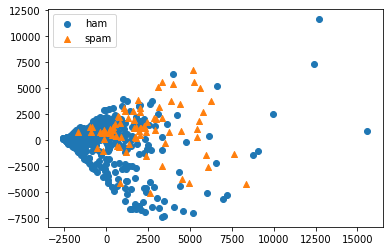

In [19]:
plt.scatter(ham[:,0], ham[:,1], marker='o', label="ham")
plt.scatter(spam[:,0], spam[:,1], marker='^', label="spam")
plt.legend()
plt.show()

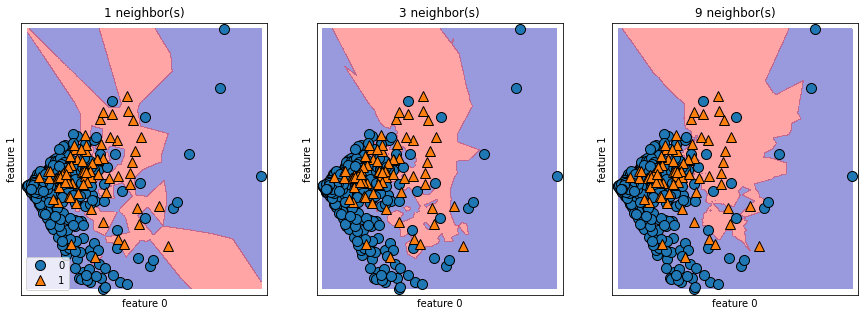

In [20]:
# Source: https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
from sklearn.neighbors import KNeighborsClassifier
import mglearn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for n_neighbors, ax in zip([1, 3, 9], axes):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(x_PCA, y_pred)
    mglearn.plots.plot_2d_separator(clf, x_PCA, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(x_PCA[:, 0], x_PCA[:, 1], y_pred, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)

